# Fine Tuning Models

## Chargement des données 

In [1]:
# Importing the librairies
import pandas as pd

# Exporting the csv file into a DataFrame pandas
chemin_fichier = "../data/data_cleaned.csv"
df = pd.read_csv(chemin_fichier)

# Convertir en entier puis extraire les deux derniers chiffres
df['arrondissement'] = df['code_postal'].astype(int) % 100

df.drop(columns="code_postal", inplace=True)
df.drop(columns='nom_commune', inplace=True)
df.drop(columns='adresse_nom_voie', inplace = True)
df.drop(columns='date_mutation', inplace=True)

In [2]:
df

,adresse_numero,adresse_code_voie,lot1_surface_carrez,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,prix_au_m2,année,arrondissement
0,13.0,9002.0,61.00,25.0,2.0,2.348168,48.884490,9508.196721,2022,18
1,51.0,1880.0,40.66,42.0,3.0,2.362871,48.863374,14879.488441,2022,3
2,134.0,3933.0,32.52,29.0,1.0,2.405513,48.872782,9840.098401,2022,20
3,9.0,3192.0,34.53,36.0,2.0,2.386648,48.869335,6371.271358,2022,20
4,18.0,4452.0,24.59,28.0,2.0,2.400622,48.852508,11386.742578,2022,20
...,...,...,...,...,...,...,...,...,...,...
73658,161.0,2112.0,50.06,52.0,3.0,2.317308,48.891974,9622.453056,2023,17
73659,25.0,2523.0,10.00,9.0,1.0,2.324411,48.884351,10700.000000,2023,17
73660,9.0,6783.0,56.88,55.0,3.0,2.347625,48.867586,12798.874824,2023,2
73661,18.0,8436.0,85.05,84.0,4.0,2.340259,48.892260,11405.055850,2023,18


In [3]:
from sklearn.model_selection import train_test_split

# On suppose que ta cible est dans la colonne 'prix_au_m2'
X = df.drop(columns='prix_au_m2')
y = df['prix_au_m2']

# Séparation des données (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


## Fine tuning RandomForest

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import numpy as np

# Grille de recherche manuelle
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Dictionnaire pour stocker les résultats
results = {
    'n_estimators': [],
    'max_depth': [],
    'min_samples_split': [],
    'mae': [],
    'rmse': [],
    'r2': []
}

# Boucle sur toutes les combinaisons de la grille
for n in tqdm(param_grid['n_estimators'], desc="n_estimators"):
    for depth in param_grid['max_depth']:
        for min_split in param_grid['min_samples_split']:
            model = RandomForestRegressor(
                n_estimators=n,
                max_depth=depth,
                min_samples_split=min_split,
                random_state=42,
                n_jobs=-1
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            # Sauvegarde
            results['n_estimators'].append(n)
            results['max_depth'].append(depth)
            results['min_samples_split'].append(min_split)
            results['mae'].append(mae)
            results['rmse'].append(rmse)
            results['r2'].append(r2)


n_estimators: 100%|██████████| 4/4 [03:26<00:00, 51.73s/it]


 Meilleure configuration trouvée :
n_estimators          200.000000
max_depth                    NaN
min_samples_split       2.000000
mae                  1574.700890
rmse                 3458.313821
r2                      0.534882
Name: 27, dtype: float64


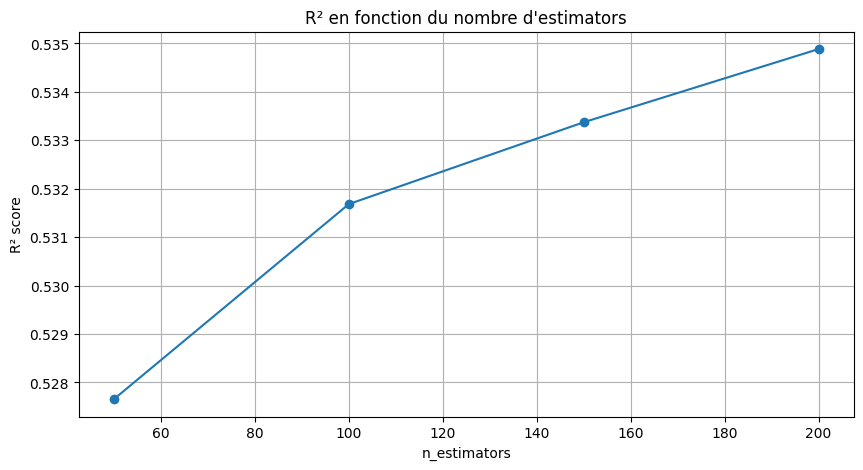

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir les résultats en DataFrame
df_results = pd.DataFrame(results)

# Meilleure configuration trouvée
best_idx = df_results['r2'].idxmax()
best_row = df_results.loc[best_idx]

print(" Meilleure configuration trouvée :")
print(best_row)

# Convertir None → chaîne de texte pour filtrage sans erreur
df_results['max_depth_str'] = df_results['max_depth'].astype(str)
best_depth_str = str(best_row['max_depth'])

# Sous-ensemble filtré pour affichage clair
subset = df_results[
    (df_results['max_depth_str'] == best_depth_str) &
    (df_results['min_samples_split'] == best_row['min_samples_split'])
]

# 🔍 Afficher si le subset est vide
if subset.empty:
    print("Le sous-ensemble est vide. Vérifie les filtres.")
else:
    # Graphe
    plt.figure(figsize=(10, 5))
    plt.plot(subset['n_estimators'], subset['r2'], marker='o')
    plt.title("R² en fonction du nombre d'estimators")
    plt.xlabel("n_estimators")
    plt.ylabel("R² score")
    plt.grid(True)
    plt.show()


## Boosting Models

In [8]:
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm
import pandas as pd
import numpy as np

# Paramètres à tester
gbr_param_grid = {
    'n_estimators': [100, 150, 200, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2, 0.5],
    'max_depth': [3, 5, 10, 30]}


hgb_param_grid = {
    'max_iter': [100, 150, 200, 300, 500],
    'learning_rate': [0.05, 0.1, 0.2, 0.5],
    'max_depth': [None, 10]
}

# Stockage des résultats
results = {
    'model': [],
    'n_estimators': [],
    'max_iter': [],
    'learning_rate': [],
    'max_depth': [],
    'mae': [],
    'rmse': [],
    'r2': []
}

# Grid search pour GradientBoostingRegressor
for n in tqdm(gbr_param_grid['n_estimators'], desc="GBR - n_estimators"):
    for lr in gbr_param_grid['learning_rate']:
        for depth in gbr_param_grid['max_depth']:
            model = GradientBoostingRegressor(
                n_estimators=n,
                learning_rate=lr,
                max_depth=depth,
                random_state=42
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            results['model'].append('GradientBoostingRegressor')
            results['n_estimators'].append(n)
            results['max_iter'].append(None)
            results['learning_rate'].append(lr)
            results['max_depth'].append(depth)
            results['mae'].append(mean_absolute_error(y_test, y_pred))
            results['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            results['r2'].append(r2_score(y_test, y_pred))

# Grid search pour HistGradientBoostingRegressor
for mi in tqdm(hgb_param_grid['max_iter'], desc="HGB - max_iter"):
    for lr in hgb_param_grid['learning_rate']:
        for depth in hgb_param_grid['max_depth']:
            model = HistGradientBoostingRegressor(
                max_iter=mi,
                learning_rate=lr,
                max_depth=depth,
                random_state=42
            )
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            results['model'].append('HistGradientBoostingRegressor')
            results['n_estimators'].append(None)
            results['max_iter'].append(mi)
            results['learning_rate'].append(lr)
            results['max_depth'].append(depth)
            results['mae'].append(mean_absolute_error(y_test, y_pred))
            results['rmse'].append(np.sqrt(mean_squared_error(y_test, y_pred)))
            results['r2'].append(r2_score(y_test, y_pred))

# Sauvegarde dans un DataFrame
df_results = pd.DataFrame(results)


HGB - max_iter: 100%|██████████| 5/5 [00:31<00:00,  6.32s/it]


✅ Meilleure configuration trouvée :
model            GradientBoostingRegressor
n_estimators                         500.0
max_iter                               NaN
learning_rate                         0.05
max_depth                             10.0
mae                             1692.17521
rmse                           3563.394446
r2                                0.506188
Name: 66, dtype: object


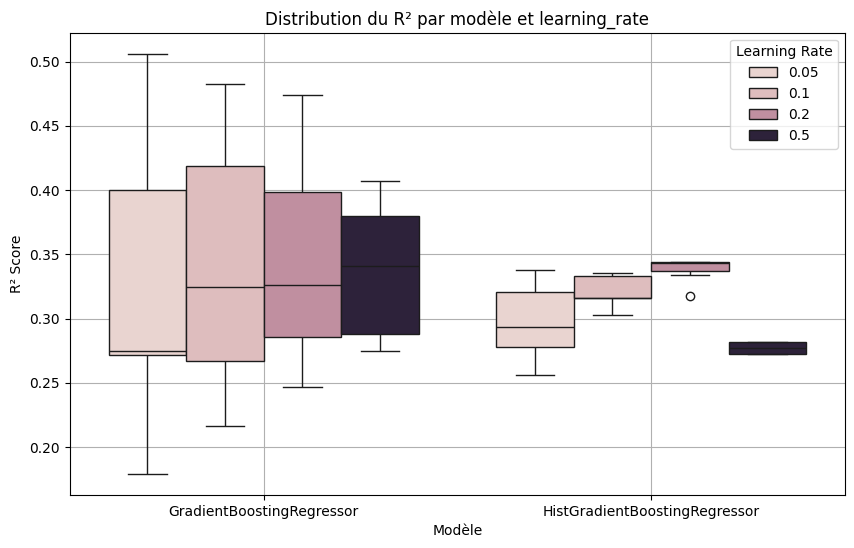

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Meilleure config
best_idx = df_results['r2'].idxmax()
best_row = df_results.loc[best_idx]
print("✅ Meilleure configuration trouvée :")
print(best_row)

# Graphique : R² selon modèle et learning rate
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_results, x='model', y='r2', hue='learning_rate')
plt.title("Distribution du R² par modèle et learning_rate")
plt.ylabel("R² Score")
plt.xlabel("Modèle")
plt.legend(title="Learning Rate")
plt.grid(True)
plt.show()
